In [1]:
import scipy
import os
import warnings
import numpy as np
from model import DGN
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch.nn
import contextlib
import sys
import helper


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Arial', 'Liberation Serif']

#### 1. inspect

#### 2. data preprocessing

In [4]:
def normalize_matrix(connectivity_matrix):
    np.fill_diagonal(connectivity_matrix, 0)
    connectivity_matrix[np.logical_or(np.isinf(connectivity_matrix), np.isnan(connectivity_matrix))] = 0
    connectivity_matrix = connectivity_matrix.astype(float)
    
    return connectivity_matrix

In [5]:
import scipy.io
import numpy as np

connectivity_matrices_asd = []

for i in range(1, 155):
    mat = scipy.io.loadmat(f'data_nc_asd_L/data_nc_asd_L/ASD_LH/LHASDSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_asd.append(connectivity_matrix)

connectivity_matrices_asd = np.stack(connectivity_matrices_asd)

connectivity_matrices_control = []

for i in range(1, 186):
    mat = scipy.io.loadmat(f'data_nc_asd_L/data_nc_asd_L/NC_LH/LHNCSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_control.append(connectivity_matrix)

connectivity_matrices_control = np.stack(connectivity_matrices_control)


In [4]:
warnings.filterwarnings("ignore", category=UserWarning)

#### 3. train DGN for ASD

In [5]:
Dataset = "E" 
N_Subjects = 155
N_Nodes = 35
N_views = 6
N_max_epochs = 500
early_stop =  True
random_sample_size = 10
n_folds = 5
lr = 0.001
model_name = "ASD_LH_10"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = CONV2 = CONV3 = 8

lambda_r = 200
lambda_b = 10
patience = 3
convergence_threshold = 0.01

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_asd
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
        "lambda_r" : lambda_r,
        "lambda_b" : lambda_b,
        "patience" : patience,
        "convergence_threshold" : convergence_threshold,
    }

In [6]:
Dataset = "E" 
N_Subjects = 186
N_Nodes = 35
N_views = 6
N_max_epochs = 500
early_stop =  True
random_sample_size = 10
n_folds = 5
lr = 0.001
model_name = "CONTROL_LH"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = CONV2 = CONV3 = 8

lambda_r = 100
lambda_b = 50
patience = 3
convergence_threshold = 0.01

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_control
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
        "lambda_r" : lambda_r,
        "lambda_b" : lambda_b,
        "patience" : patience,
        "convergence_threshold" : convergence_threshold,
    }

lambda r 100.0 lambda b 50.0
********* FOLD 0 *********
Epoch: 0  |  cbt loss : 26.33 | reservoir loss : 0.0935 | bio loss : 0.85762 | total loss: 71.08 | median cbt mc 9.30 | Time Elapsed: 20.04 | 
Epoch: 10  |  cbt loss : 18.58 | reservoir loss : 0.0928 | bio loss : 0.85673 | total loss: 61.42 | median cbt mc 9.28 | Time Elapsed: 52.66 | 
Epoch: 20  |  cbt loss : 15.61 | reservoir loss : 0.0926 | bio loss : 0.62615 | total loss: 46.91 | median cbt mc 10.26 | Time Elapsed: 52.89 | 
Epoch: 30  |  cbt loss : 13.79 | reservoir loss : 0.0925 | bio loss : 0.60825 | total loss: 44.20 | median cbt mc 10.26 | Time Elapsed: 51.75 | 
Epoch: 40  |  cbt loss : 12.90 | reservoir loss : 0.0925 | bio loss : 0.61573 | total loss: 43.69 | median cbt mc 10.27 | Time Elapsed: 59.92 | 
Epoch: 50  |  cbt loss : 12.34 | reservoir loss : 0.0925 | bio loss : 0.61451 | total loss: 43.07 | median cbt mc 10.26 | Time Elapsed: 88.54 | 
Epoch: 60  |  cbt loss : 11.94 | reservoir loss : 0.0925 | bio loss : 0.58689

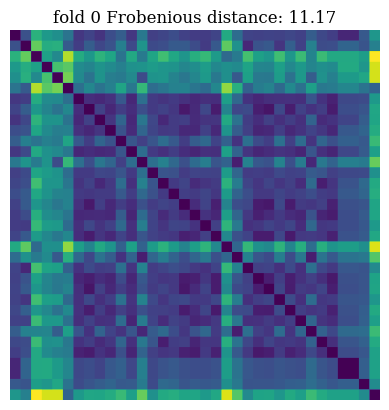

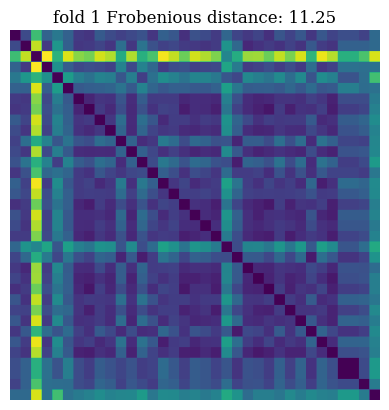

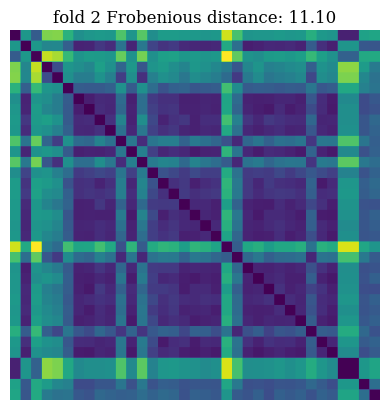

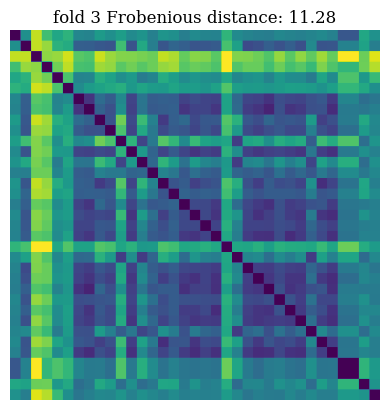

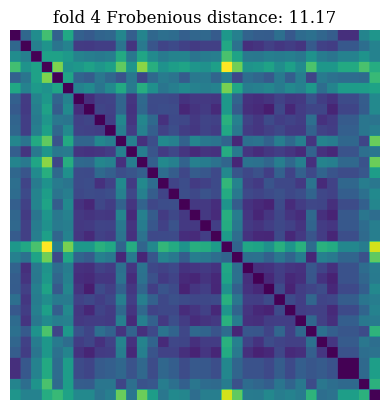

In [7]:
# lambda2 = 10
np.random.seed(35813)
torch.manual_seed(35813)
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])

### analysis

In [ ]:
import numpy as np

memory_capacity_asd = [
10.420306825907831,
10.41758759066618,
9.4824501569226,
10.402180811410492,
10.40873418522438,
]

bio = [
0.5837880665841213,
0.5808939106200185,
0.8458321017430267,
0.5906528289411027,
0.6052660391002331,
]

fb = [
11.058042526245117,
11.262124061584473,
11.099261283874512,
11.223647117614746,
11.210760116577148,
]

print("asd",  "memory capacity", np.mean(memory_capacity_asd), np.std(memory_capacity_asd), "bio", np.mean(bio), np.std(bio), "fb", np.mean(fb), np.std(fb))

asd memory capacity 10.226251914026296 0.37195657275751143 bio 0.6412865893977004 0.10261917962837987 fb 11.170767021179199 0.0781815110314246


In [ ]:
memory_capacity_nc = [
10.439034252129735,
10.399845815606573,
9.450688410289498,
10.424946801185682,
10.393719656423729,
]

bio = [
0.6101109198497288,
0.6014396908217643,
0.6375407608747983,
0.6067441765706362,
0.5671873952963586,
]

fb = [
11.176233291625977,
11.251970291137695,
11.09891414642334,
11.271895408630371,
11.168896675109863,
]

print("nc",  "memory capacity", np.mean(memory_capacity_nc), np.std(memory_capacity_nc), "bio", np.mean(bio), np.std(bio), "fb", np.mean(fb), np.std(fb))

nc memory capacity 10.221646987127043 0.385831307846153 bio 0.6046045886826572 0.022493340780327702 fb 11.19358196258545 0.0623129648809479


In [ ]:
import numpy as np

# lambda2 = 25
memory_capacity_asd = [
10.419438904090883,
10.42221893351354,
9.457892840615951,
10.40242743248542,
10.4075582901154,
]

bio = [
0.5838727552381158,
0.5950854845363363,
0.8415820917717504,
0.5906511758514541,
0.6053973040812479,
]

fb = [
11.057658195495605,
11.265524864196777,
11.084229469299316,
11.225045204162598,
11.210065841674805,
]

print("asd",  "memory capacity", np.mean(memory_capacity_asd), np.std(memory_capacity_asd), "bio", np.mean(bio), np.std(bio), "fb", np.mean(fb), np.std(fb))

asd memory capacity 10.22190728016424 0.3820773187842639 bio 0.6433177622957809 0.09937860564870463 fb 11.16850471496582 0.08212957011885381


In [1]:
import numpy as np

# lambda2 = 5
memory_capacity_asd = [
10.41530253576178,
10.419824716804905,
9.455900713121013,
10.403035576685104,
10.32011134984295,
]

bio = [
0.5838626313733793,
0.5808004288201137,
0.8381407243013845,
0.5734582597625408,
0.5699663415169898,
]

fb = [
11.057449340820312,
11.262213706970215,
11.100473403930664,
11.017168998718262,
11.188461303710938,
]

print("asd",  "memory capacity", np.mean(memory_capacity_asd), np.std(memory_capacity_asd), "bio", np.mean(bio), np.std(bio), "fb", np.mean(fb), np.std(fb))

asd memory capacity 10.20283497844315 0.3752257541813221 bio 0.6292456771548817 0.10456574891037698 fb 11.125153350830079 0.08904716859574516


In [ ]:
# lambda2 = 25
memory_capacity_nc = [
10.43794027533583,
10.421288848182224,
9.44829360856739,
10.426338502818421,
10.378153207959633,
]

bio = [
0.6100456184067462,
0.6014883063611414,
0.6503197744164863,
0.6068143996041272,
0.5671054260399809,
]

fb = [
11.177300453186035,
11.252564430236816,
11.098559379577637,
11.271883964538574,
11.170321464538574,
]

print("nc",  "memory capacity", np.mean(memory_capacity_nc), np.std(memory_capacity_nc), "bio", np.mean(bio), np.std(bio), "fb", np.mean(fb), np.std(fb))

nc memory capacity 10.2224028885727 0.38758355593593774 bio 0.6071547049656963 0.02648678623226958 fb 11.194125938415528 0.062360380131589524
